# Angle-Shifted Frequency-Based Line Pattern Recognition

This notebook explores how to recognize **repetitive linear patterns** (straight or nearly straight line structures) using frequency-domain representations, controlled rotations, and attention-based models. It is organized into several stages:
- Synthetic line generation in the Fourier domain and image rendering
- Rotation, straightening, and augmentation of line images
- Dataset pipeline for supervised learning
- Attention-based model for line mask prediction
- Evaluation with rotations and frequency-guided masks
- Gaussian-mixture-based frequency extraction and clustering of line structures
- Vector proposal generation, matching, and non-max suppression in vector space.

In [1]:
import os
import sys
sys.path.append(os.path.abspath("../"))

from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import math
import seaborn as sns
import cv2 as cv
from src.utils import reload_script
import warnings

2024-04-09 09:55:52.326940: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-09 09:55:52.375611: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-09 09:55:52.629405: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-09 09:55:52.631334: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-09 09:55:53.847855: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

## 1. Synthetic Line Generation and Imports

The first cells load all required libraries and project utilities for Fourier-based line generation and vector drawing. These tools allow us to **synthesize repetitive line patterns** directly in the frequency domain (via `FreqLinesGenerator`) and render them into spatial images (via `VecDrawer`). This synthetic setup provides full control over line orientations, frequencies, and masks, which is crucial for constructing a rich training set for line-pattern recognition.

In [2]:
#reload_script('models_src.Hough')

In [3]:
from models_src.Hough import FreqLinesGenerator, VecDrawer, VecDataset, freq_decoder
from models_src.fft_lib import xy_coords, FFT2D, amp_and_phase, top_k2D
from models_src.Attn_variations import UnSqueezeImg, SqueezeImg
from models_src.DETR import FFN, MHA, HeadsPermuter
from models_src.Metrics import WeightedF12D
from models_src.Support import LRCallback
%matplotlib inline

/home/fzzyfoxx/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Angle-Dependent Straightening in the Frequency Domain

The functions below (`gen_straightening_matrix`, `straighten_img`, `randomize_slopes`, `rot90_preprocessing`) implement **angle-aware straightening** of line images using Fourier-domain operations. Key ideas:
- Represent each image in the frequency domain and compute a complex phase-shift matrix that compensates for the line slope.
- Use `rot90_preprocessing` to rotate images by multiples of 90° to bring lines closer to canonical orientations before fine straightening.
- Randomize slopes to augment the data and encourage robustness to small orientation errors.
These transformations help the model see lines as near-horizontal patterns in a canonical frame, simplifying the learning problem for repetitive linear structures.

In [4]:
def gen_straightening_matrix(slopes, size=32):
    x = tf.range(size, dtype=tf.float32)[tf.newaxis]
    Dshifts = tf.math.round(x/-slopes)/size
    shift_angle = Dshifts[:,:,tf.newaxis]*2*math.pi*x[:,tf.newaxis]
    D = tf.complex(tf.cos(shift_angle), -tf.sin(shift_angle))

    return D[:,tf.newaxis]

def straighten_img(I, D):
    Ix = tf.transpose(I, [0,3,1,2])
    Fi = tf.signal.fft(tf.cast(Ix, tf.complex64))

    Fid = Fi*D
    Id = tf.transpose(tf.math.real(tf.signal.ifft(Fid)), [0,2,3,1])

    return Id

def randomize_slopes(slopes, rand_range=0.1):
    diff = tf.random.uniform(slopes.shape, -rand_range, rand_range)
    angles = tf.math.atan(-slopes)+diff
    rand_slopes = tf.tan(-angles)

    return rand_slopes

def rot90_preprocessing(angles, I, masks, freqs, examples_num=3):
    abs_angle = tf.abs(tf.abs(angles/math.pi)-0.5)
    rot_k = tf.where(abs_angle<0.25, 0, 1)
    slopes = tf.tan(-angles)

    rot_slopes = []
    rot_masks = []
    rot_I = []
    rot_freqs = []

    #for k, s, m, fq in zip(rot_k, slopes, masks, freqs):
    for i in range(examples_num):
        s = slopes[i]
        rot_I.append(tf.image.rot90(I, k=rot_k[i,0]))
        rot_masks.append(tf.image.rot90(masks[i], k=rot_k[i,0]))
        rot_freqs.append(tf.image.rot90(freqs[i], k=rot_k[i,0]))
        rot_slopes.append(-1/s if rot_k[i,0]!=0 else s)

    rot_slopes = tf.stack(rot_slopes, axis=0)
    rot_I = tf.stack(rot_I, axis=0)
    rot_masks = tf.stack(rot_masks, axis=0)
    rot_freqs = tf.stack(rot_freqs, axis=0)

    return rot_slopes, rot_I, rot_masks, rot_freqs

## 3. VecRotDataset: Rotated and Straightened Line Dataset

`VecRotDataset` encapsulates the entire pipeline that turns random Fourier-domain line parameters into **batches of straightened images, frequency maps, and masks**. Its main responsibilities:
- Sample diverse line frequencies and orientations with `FreqLinesGenerator`.
- Render line vectors into RGB images and corresponding binary masks with `VecDrawer`.
- Apply rotation and straightening steps to align lines into a normalized orientation.
- Smooth masks to produce more stable training labels.
- Reshape batched outputs so that each straightened example can be used as an independent training sample.
This dataset provides **highly structured supervision** for recognizing repetitive, oriented patterns, while preserving explicit access to both spatial and frequency information.

In [5]:
class VecRotDataset():
    def __init__(self, 
                 batch_size=16, 
                 examples_num=3,
                 mask_smoothing_levels=1,
                 angle_rand_range=0.05, 
                 min_width=0.2, 
                 min_lines_num=2, 
                 parallel_calls=4, 
                 size=32):

        self.flg = FreqLinesGenerator(size = size)
        self.batch_size = batch_size
        self.examples_num = examples_num
        self.vd = VecDrawer(min_width=min_width, min_num=min_lines_num, size=size)
        self.parallel_calls = parallel_calls
        self.size = size
        self.rand_range = angle_rand_range

        self.smoothing_levels = mask_smoothing_levels

    def _gen_parameters(self, *args):
        Xuv, phase = self.flg.random_freqs(examples_num=20)
        vecs_col, lengths, lines_mask, vecs_slope, vecs_bias, Iuvx, vec_angle = self.flg.gen_vecs(Xuv, phase)

        choosen = vec_angle[:1,0]
        args = [tf.constant(0, tf.int64)]
        for i in range(self.examples_num-1):
            diffs = tf.reduce_mean(tf.sin((choosen[tf.newaxis])-vec_angle[:,tf.newaxis,0])**2, axis=-1)
            fp = tf.argmax(diffs, axis=0)
            args.append(fp)
            choosen = tf.concat([choosen, tf.gather(vec_angle[:,0], fp)[tf.newaxis]], axis=0)

        Xuv, phase, vecs_col, lengths, lines_mask, vecs_slope, vecs_bias, Iuvx, vec_angle = [tf.gather(a, args, axis=0) for a in [Xuv, phase, vecs_col, lengths, lines_mask, vecs_slope, vecs_bias, Iuvx, vec_angle]]

        return vecs_col, lengths, lines_mask, vec_angle, phase, Iuvx
    
    def _map_drawing(self, vecs_col, lengths, lines_mask, vec_angle, phase, Iuvx):
        I, masks, _, _ = tf.py_function(self.vd.draw_vecs, [vecs_col, lines_mask, lengths], [tf.float32, tf.float32, tf.float32, tf.float32])
        I.set_shape((self.size,self.size,3))
        return vec_angle, I, masks, Iuvx 
    
    def _mask_smoothing(self, Md):
        smooth_Md = Md
        for i in range(self.smoothing_levels):
            smooth_Md = tf.nn.avg_pool2d(smooth_Md, 3, 1, padding='SAME')
        
        return tf.reduce_max(tf.concat([Md, smooth_Md], axis=-1), axis=-1, keepdims=True)
        
    
    def _rot(self, vec_angle, I, masks, Iuvx):
        rot_slopes, rot_I, rot_masks, rot_freqs = rot90_preprocessing(vec_angle, I, masks, Iuvx[...,tf.newaxis], examples_num=self.examples_num)
        rand_slopes = randomize_slopes(rot_slopes, rand_range=self.rand_range)
        D = gen_straightening_matrix(rand_slopes, size=self.size)
        Id = tf.clip_by_value(straighten_img(rot_I, D), 0.0, 1.0)
        Md = tf.round(straighten_img(rot_masks, D))
        Fd = tf.round(straighten_img(rot_freqs, D))

        Md = self._mask_smoothing(Md)
        return Id, Fd, Md
    
    def _squeeze_batch(self, features, freqs, labels):
        return ((tf.reshape(features, (self.batch_size*self.examples_num, self.size, self.size, 3)), 
                tf.reshape(freqs, (self.batch_size*self.examples_num, self.size, self.size, 1))),
                tf.reshape(labels, (self.batch_size*self.examples_num, self.size, self.size)))
    
    def new_dataset(self):
        ds = tf.data.Dataset.range(self.batch_size*2)
        ds = ds.map(self._gen_parameters, num_parallel_calls=self.parallel_calls)
        ds = ds.map(self._map_drawing, num_parallel_calls=self.parallel_calls)
        ds = ds.map(self._rot, num_parallel_calls=self.parallel_calls)
        ds = ds.batch(self.batch_size)
        ds = ds.map(self._squeeze_batch)
        ds = ds.repeat()

        return ds

## 4. Dataset Sampling and Visualization

These cells instantiate `VecRotDataset`, draw samples, and visualize input images, frequency channels, and masks. The goal is to **validate the preprocessing pipeline** and to qualitatively inspect how well the straightening and masking capture the dominant line structures. By plotting several examples side-by-side, we can check:
- Diversity in line orientations and configurations.
- Alignment of masks with visible linear patterns.
- Consistency between spatial inputs and their frequency representations.
Such visual checks are essential before training a model for line-pattern recognition.

In [6]:
vrd = VecRotDataset(
    batch_size=4, 
    examples_num=3,
    mask_smoothing_levels=0,
    angle_rand_range=0.05, 
    min_width=0.2, 
    min_lines_num=2, 
    parallel_calls=4, 
    size=64
    )

ds = vrd.new_dataset()

In [7]:
features, labels = next(iter(ds))
features, freqs = features
features.shape, freqs.shape, labels.shape

(TensorShape([12, 64, 64, 3]),
 TensorShape([12, 64, 64, 1]),
 TensorShape([12, 64, 64]))

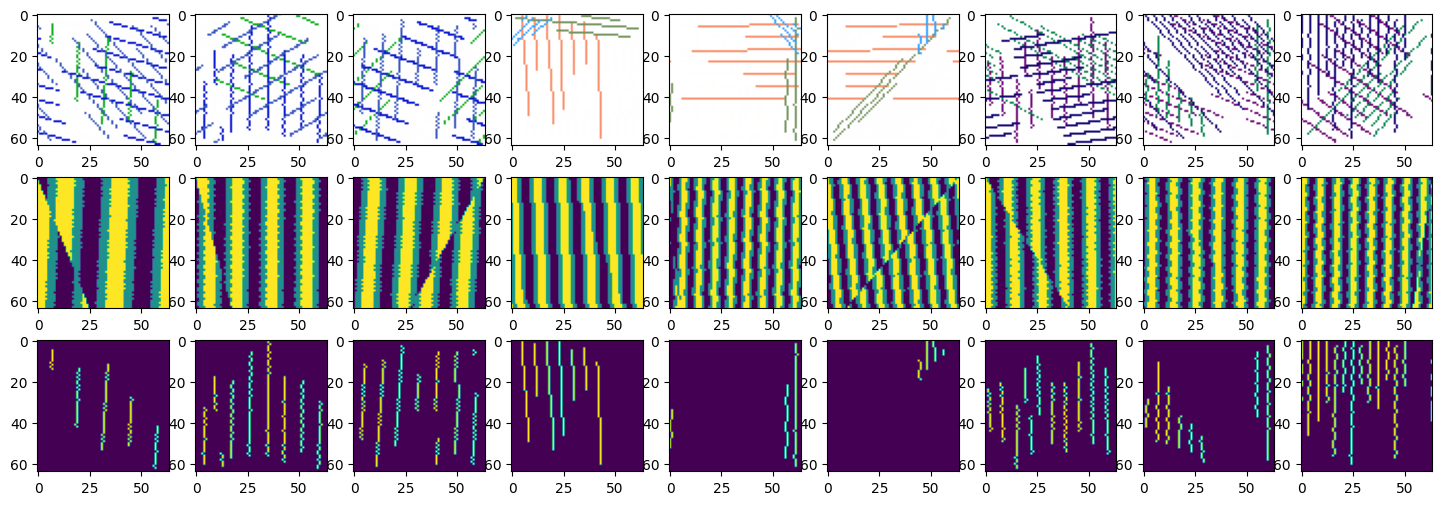

In [8]:
fig, axs = plt.subplots(3,9, figsize=(18,6))

for i in range(9):
    img = features[i]
    axs[0,i].imshow(img)
    axs[1,i].imshow(freqs[i])
    axs[2,i].imshow(labels[i])

## 5. Fourier-Domain Experiments for Angle and Shift Intuition

The experimental cells following this section explore explicit construction of images from known frequency components and phases. They are used to **build intuition** about:
- How specific frequency vectors correspond to oriented line patterns in the spatial domain.
- How rotations and phase shifts affect the resulting line structures.
This helps in interpreting the later steps where frequency-domain reasoning is used to design data augmentation and feature extraction for repetitive linear patterns.

In [5]:
'''xy = xy_coords((32,32))
rot_Xuv = freq_decoder(math.pi/2, lengths)
angle = xy[tf.newaxis]*rot_Xuv[:,tf.newaxis, tf.newaxis]/32*2*math.pi

rot_Iuvx = tf.cos(tf.reduce_sum(angle, axis=-1))'''

'xy = xy_coords((32,32))\nrot_Xuv = freq_decoder(math.pi/2, lengths)\nangle = xy[tf.newaxis]*rot_Xuv[:,tf.newaxis, tf.newaxis]/32*2*math.pi\n\nrot_Iuvx = tf.cos(tf.reduce_sum(angle, axis=-1))'

In [14]:
flg = FreqLinesGenerator()
vd = VecDrawer(min_width = 0.2, min_num=2)

In [106]:
Xuv, phase = flg.random_freqs(examples_num=20)
vecs_col, lengths, lines_mask, vecs_slope, vecs_bias, Iuvx, vec_angle = flg.gen_vecs(Xuv, phase)

In [41]:
[a.shape for a in [vecs_col, lengths, lines_mask, vecs_slope, vecs_bias, Iuvx, vec_angle,Xuv, phase]]

[TensorShape([20, 32, 2, 2]),
 TensorShape([20, 1]),
 TensorShape([20, 32]),
 TensorShape([20, 1]),
 TensorShape([20, 32]),
 TensorShape([20, 32, 32]),
 TensorShape([20, 1]),
 TensorShape([20, 2]),
 TensorShape([20, 1])]

In [123]:
Xuv, phase = flg.random_freqs(examples_num=20)
vecs_col, lengths, lines_mask, vecs_slope, vecs_bias, Iuvx, vec_angle = flg.gen_vecs(Xuv, phase)

choosen = vec_angle[:1,0]
args = [tf.constant(0, tf.int64)]
for i in range(2):
    diffs = tf.reduce_mean(tf.sin((choosen[tf.newaxis])-vec_angle[:,tf.newaxis,0])**2, axis=-1)
    fp = tf.argmax(diffs, axis=0)
    args.append(fp)
    choosen = tf.concat([choosen, tf.gather(vec_angle[:,0], fp)[tf.newaxis]], axis=0)

Xuv, phase, vecs_col, lengths, lines_mask, vecs_slope, vecs_bias, Iuvx, vec_angle = [tf.gather(a, args, axis=0) for a in [Xuv, phase, vecs_col, lengths, lines_mask, vecs_slope, vecs_bias, Iuvx, vec_angle]]

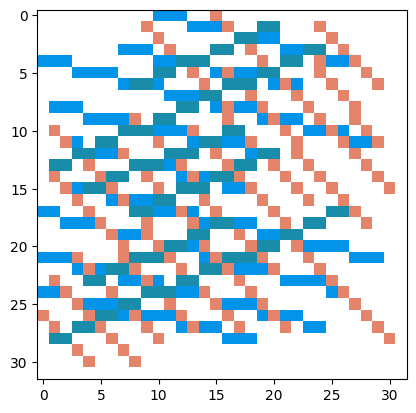

In [125]:
Xuv, phase = flg.random_freqs(examples_num=3)
vecs_col, lengths, lines_mask, vecs_slope, vecs_bias, Iuvx, vec_angle = flg.gen_vecs(Xuv, phase)
I, masks = vd.draw_vecs(vecs_col, lines_mask, lengths)

plt.imshow(I)

In [128]:
angles = vec_angle
freqs = Iuvx[...,tf.newaxis]
examples_num = 3

abs_angle = tf.abs(tf.abs(angles/math.pi)-0.5)
rot_k = tf.where(abs_angle<0.25, 0, 1)
slopes = tf.tan(-angles)

rot_slopes = []
rot_masks = []
rot_I = []
rot_freqs = []

#for k, s, m, fq in zip(rot_k, slopes, masks, freqs):
for i in range(examples_num):
    s = slopes[i]
    rot_I.append(tf.image.rot90(I, k=rot_k[i,0]))
    rot_masks.append(tf.image.rot90(masks[i], k=rot_k[i,0]))
    rot_freqs.append(tf.image.rot90(freqs[i], k=rot_k[i,0]))
    rot_slopes.append(-1/s if rot_k[i,0]!=0 else s)

In [127]:
vec_angle.shape, I.shape, masks.shape, Iuvx[...,tf.newaxis].shape

(TensorShape([3, 1]),
 TensorShape([32, 32, 3]),
 TensorShape([3, 32, 32, 1]),
 TensorShape([3, 32, 32, 1]))

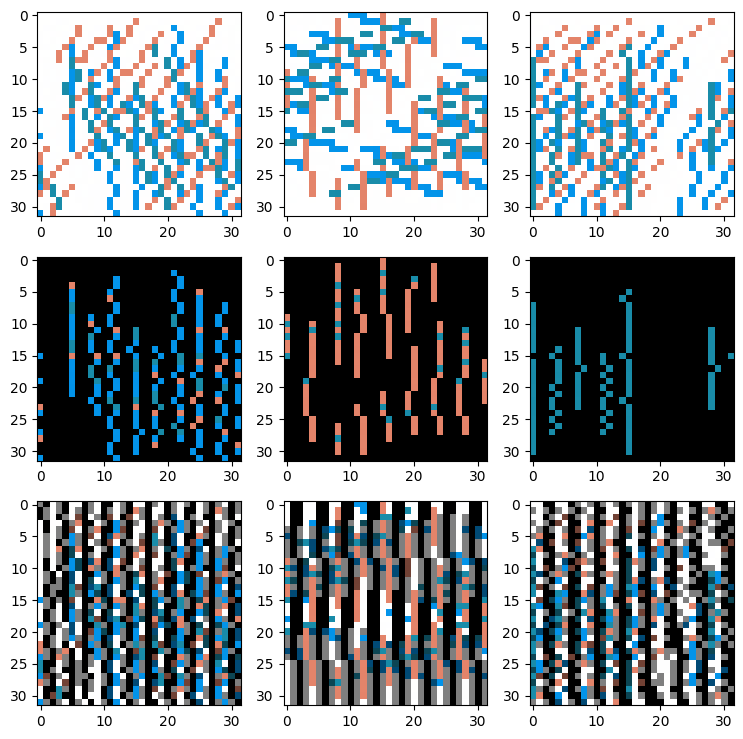

In [130]:
rot_slopes, rot_I, rot_masks, rot_freqs = rot90_preprocessing(vec_angle, I, masks, Iuvx[...,tf.newaxis])
rand_slopes = randomize_slopes(rot_slopes, rand_range=0.001)
D = gen_straightening_matrix(rand_slopes)
Id = tf.clip_by_value(straighten_img(rot_I, D), 0.0, 1.0)
Md = tf.round(straighten_img(rot_masks, D))
Fd = tf.round(straighten_img(rot_freqs, D))

fig, axs = plt.subplots(3, 3, figsize=(9,9))
for i in range(3):
    axs[0,i].imshow(Id[i])
    axs[1,i].imshow(Md[i]*Id[i])
    axs[2,i].imshow((Fd[i]+1)/2*Id[i])

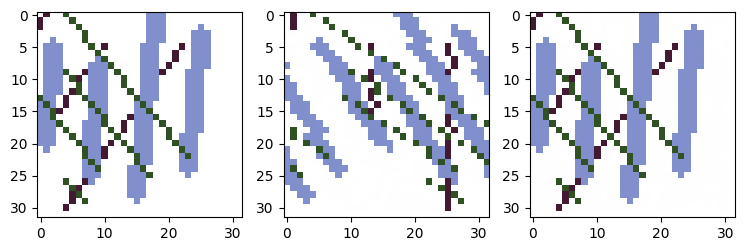

In [116]:
Id = tf.clip_by_value(straighten_img(rot_I, D), 0.0, 1.0)
Id2 = tf.clip_by_value(straighten_img(Id, 1/D), 0.0, 1.0)

fig, axs = plt.subplots(1,3, figsize=(9,3))

axs[0].imshow(rot_I[0])
axs[1].imshow(Id[0])
axs[2].imshow(Id2[0])

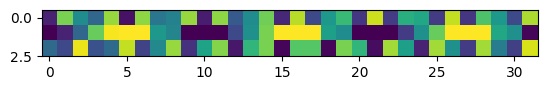

In [9]:
plt.imshow(tf.reduce_mean(Fd[...,0], axis=1))

## 6. Attention-Based Model for Line Mask Prediction

The following section defines a **sequence-style attention model** to predict line masks from straightened images and their frequency channels. Main components:
- A configurable 1D residual convolution backbone (`ResidualConvBlock1D`, `gen_backbone`) for hierarchical feature extraction along one spatial dimension.
- Positional encodings (`AddPosEnc`) that preserve ordering information along the line-aligned dimension.
- Multi-head attention encoder blocks (`EncoderLayer`, `MHA`, `FFN`) that model long-range dependencies between frequency-aligned features.
The model treats each straightened image as a sequence and learns to highlight positions that belong to linear structures, leveraging both spatial and Fourier-domain cues.

In [7]:
@tf.keras.saving.register_keras_serializable()
class ResidualConvBlock1D(tf.keras.layers.Layer):
    def __init__(self, filters, length=2, kernel_size=3, activation='relu', strides=1, batch_norm=True, **kwargs):
        super(ResidualConvBlock1D, self).__init__(**kwargs)

        self.convs = tf.keras.Sequential(([tf.keras.layers.BatchNormalization()] if batch_norm else [])+[tf.keras.layers.Conv1D(filters, 
                                                                 kernel_size, 
                                                                 strides=(strides if i==0 else 1), 
                                                                 padding='same', 
                                                                 activation=(activation if i<length-1 else None),
                                                                 kernel_initializer='he_normal')
                                          for i in range(length)])
        
        if strides>1:
            self.skip_conv = tf.keras.layers.Conv1D(filters, 1, strides=strides, padding='same', activation=None, kernel_initializer='he_normal')

        self.do_skip_conv = True if strides>1 else False

        self.out_activation = tf.keras.layers.Activation(activation)

    def call(self, inputs, training=None):
        memory = inputs
        x = self.convs(memory, training=training)
        if self.do_skip_conv:
            memory = self.skip_conv(memory, training=training)
        
        return self.out_activation(x + memory)


def gen_residual_stage(x, filters, name, stage_length=3, block_length=2, kernel_size=3, activation='relu', strides=2, batch_norm=True):
    for i in range(stage_length):
        x = ResidualConvBlock1D(filters, block_length, kernel_size, activation, (strides if i==0 else 1), batch_norm, name=f'{name}-{i+1}')(x)
    return x

def gen_backbone(filters, stage_lengths, strides_list, block_length=2, kernel_size=3, activation='relu', batch_norm=True, input_shape=(32,32,3), name='Backbone'):
    inputs = tf.keras.layers.Input(input_shape, name='IMG-Input')
    x = inputs
    i=1
    for stage_length, strides in zip(stage_lengths, strides_list):
        x = gen_residual_stage(x, filters, f'Res-Stage-{i}',stage_length, block_length, kernel_size, activation, strides, batch_norm)
        i += 1
        filters *= 2

    return tf.keras.Model(inputs, x, name=name)

In [8]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

class AddPosEnc(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        self.pos_enc = positional_encoding(input_shape[-2], input_shape[-1])[tf.newaxis]

    def call(self, inputs):
        return inputs+self.pos_enc    

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, 
                 attn_dim=512, 
                 key_dim=512, 
                 num_heads=4, 
                 dropout=0.0,
                 FFN_mid_layers=1, 
                 FFN_mid_units=2048,
                 FFN_activation='relu',
                 **kwargs):
        super(EncoderLayer, self).__init__(**kwargs)

        self.attn_dropout, self.output_dropout = [tf.keras.layers.Dropout(dropout) for _ in range(2)]
        self.attn_addnorm, self.output_addnorm = [tf.keras.Sequential([
            tf.keras.layers.Add(),
            tf.keras.layers.LayerNormalization(axis=-2)])
            for _ in range(2)]

        self.FFN = FFN(FFN_mid_layers, FFN_mid_units, attn_dim, dropout, FFN_activation)

        self.MHA = MHA(attn_dim, attn_dim, key_dim, num_heads)

    def call(self, V, Q=None, K=None, training=None):

        if Q is None:
            Q = V

        if K is None:
            K = V

        # Multi-Head-Attention
        V = self.attn_addnorm([V, self.attn_dropout(self.MHA(V, Q, K), training=training)])

        # Feed-Forward-Network
        V = self.output_addnorm([V, self.output_dropout(self.FFN(V), training=training)])

        return V

In [174]:
backbone = gen_backbone(
    filters=16,
    stage_lengths=[3,3,2],
    strides_list=[2,2,2],
    block_length=2,
    kernel_size=3,
    activation='relu',
    batch_norm=False,
    input_shape=(32,32,3)
)

In [99]:
inputs = tf.keras.layers.Input((32,32,3))
freqs = tf.keras.layers.Input((32,32,1))

V = tf.keras.layers.Permute((2,1,3))(inputs)
#V = backbone(V)
V = tf.keras.layers.Reshape((32,-1))(V)

attn_dim = 128#V.shape[-1]
pos_enc = AddPosEnc()

V = FFN(mid_layers=5, mid_units=attn_dim, output_units=attn_dim, dropout=0.0, activation='relu')(V)

f = tf.keras.layers.Permute((2,1,3))(freqs)
f = tf.keras.layers.Reshape((32,-1))(f)
f = FFN(mid_layers=5, mid_units=attn_dim, output_units=attn_dim, dropout=0.0, activation='relu')(f)

for i in range(8):
        Q = K = pos_enc(V)+f
        V = EncoderLayer(
            attn_dim=attn_dim,
            key_dim=attn_dim,
            num_heads=8,
            dropout=0.0,
            FFN_mid_layers=4,
            FFN_mid_units=attn_dim*2,
            FFN_activation='relu',
            name=f'Encoder_{i+1}'
        )(V, Q, K)

V = FFN(mid_layers=4, mid_units=attn_dim, output_units=32, dropout=0.2, activation='relu')(V)
out = tf.keras.activations.sigmoid(V)
out = tf.keras.layers.Permute((2,1))(out)
model = tf.keras.Model((inputs, freqs), out)

model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 permute_261 (Permute)       (None, 32, 32, 3)            0         ['input_17[0][0]']            
                                                                                                  
 input_18 (InputLayer)       [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 reshape_262 (Reshape)       (None, 32, 96)               0         ['permute_261[0][0]']         
                                                                                            

In [118]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(1e-3),
    loss = tf.keras.losses.BinaryFocalCrossentropy(alpha=0.4, gamma=2.0), #tf.keras.losses.BinaryCrossentropy(),
    metrics = [WeightedF12D(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [ ]:
model.fit(ds, epochs=40, steps_per_epoch=100, callbacks=[
    LRCallback(warmup_lr=1e-4, warmup_epochs=0, decay_ratio=0.9)])

## 7. Training and Qualitative Evaluation

The next cells build, compile, and train the model using the generated dataset, then visualize predictions versus ground-truth masks. The focus is to assess:
- Whether the model can accurately segment straightened line patterns.
- Robustness of predictions under random slope perturbations introduced in the preprocessing.
- Visual alignment of predicted masks with repetitive linear structures in the input.
This stage demonstrates how the frequency-aware preprocessing and attention architecture work together for repetitive line recognition.

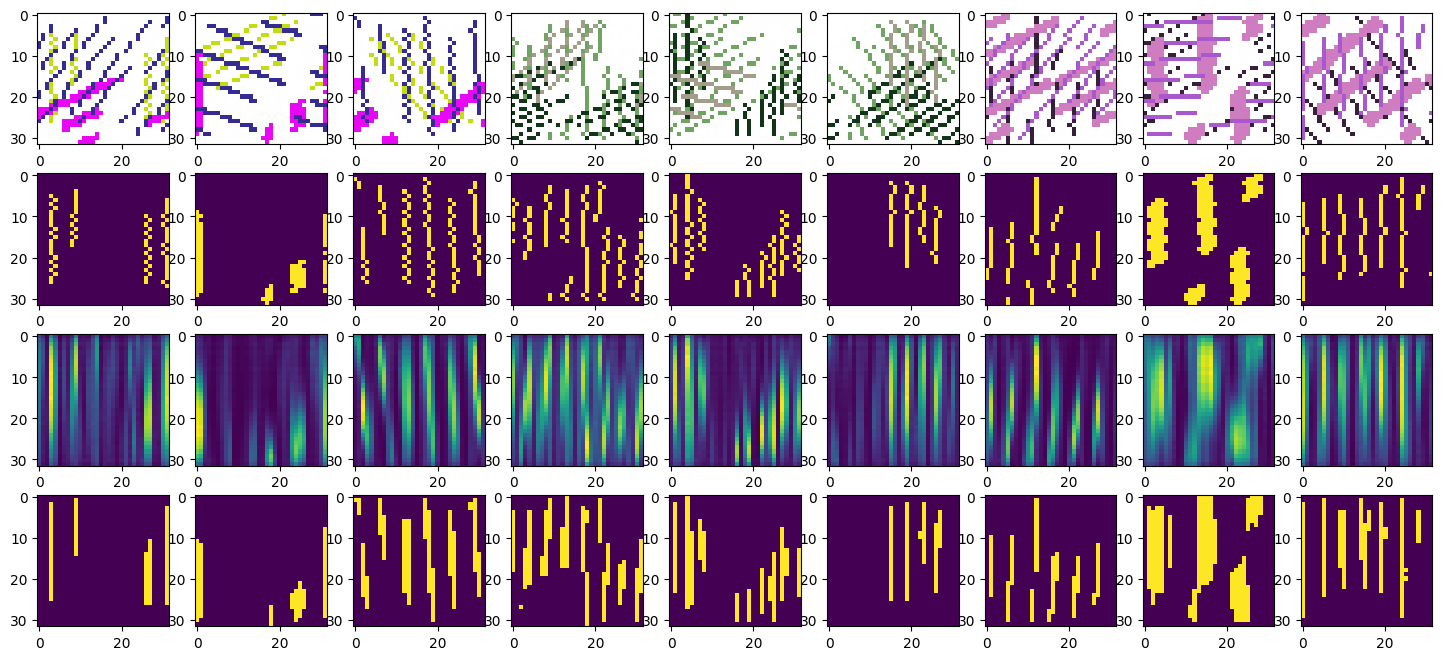

In [10]:
features, labels = next(iter(ds))
preds = model(features)
features, freqs = features

fig, axs = plt.subplots(4,9, figsize=(18,8))

for i in range(9):
    img = features[i]
    axs[0,i].imshow(img)
    axs[1,i].imshow(labels[i])
    axs[2,i].imshow(preds[i])
    axs[3,i].imshow(tf.where(preds[i]>0.4, 1.0, 0.0))

### save & load

In [104]:
model.save('./saved/lines_detection_v0_freqposenc.h5')

/home/fzzyfoxx/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
model = tf.keras.models.load_model('./saved/lines_detection_v0_freqposenc.h5', custom_objects={'WeightedF12D': WeightedF12D, 
                                                                          'FFN': FFN, 
                                                                          'ResidualConvBlock1D': ResidualConvBlock1D, 
                                                                          'EncoderLayer': EncoderLayer,
                                                                          'AddPosEnc': AddPosEnc})

## 8. Gaussian Mixture Clustering of Line Intensities

Starting here, the notebook investigates **Gaussian Mixture Models (GMMs)** as a way to cluster pixel intensities and isolate groups of coherent line structures. This serves multiple purposes:
- Decomposing complex line images into simpler, cluster-specific masks.
- Providing approximate segmentation of overlapping or intersecting linear patterns.
- Supplying cluster-wise supervision and analysis for frequency extraction methods.
The `GaussianMixtureComponents` helper turns an image into multiple soft segments, each highlighting different repetitive line subsets.

In [6]:
from sklearn.mixture import GaussianMixture
from scipy.optimize import linear_sum_assignment

In [7]:
class TopKFreqs(tf.keras.layers.Layer):
    def __init__(self, freq_filter_size=2, pool_size=3, top_k=20, size=32, **kwargs):
        super().__init__(**kwargs)

        self.xy = xy_coords((size, size))
        self.zero_freq_mask = tf.pad(tf.zeros((freq_filter_size,freq_filter_size)), [[0,size-freq_filter_size],[0,size-freq_filter_size]], constant_values=1.)
        self.zero_freq_mask = (self.zero_freq_mask*self.zero_freq_mask[:,::-1])
        self.zero_freq_mask = (self.zero_freq_mask*self.zero_freq_mask[::-1,:])[tf.newaxis]
        self.upper_mask = tf.cast(tf.where(tf.reduce_sum(self.xy, axis=-1)[...,tf.newaxis]>tf.cast(size, tf.float32), 0, 1), tf.float32)[tf.newaxis]

        self.fft = FFT2D()
        self.squeeze = SqueezeImg()

        self.pool_size = pool_size
        self.k = top_k
        self.size = size

    def draw_freqs(self, Xuv, phase):
        angle = self.xy[tf.newaxis,tf.newaxis]*Xuv[:,:,tf.newaxis, tf.newaxis]/self.size*2*math.pi

        Iuvx = tf.cos(phase[:,:,tf.newaxis]*math.pi+tf.reduce_sum(angle, axis=-1))

        return Iuvx

    def call(self, inputs):

        F = FFT2D()(inputs)
        amp, ph = amp_and_phase(F)
        amp = amp/tf.reduce_max(SqueezeImg()(amp), axis=-2, keepdims=True)[:,tf.newaxis]

        amp_arg_max = tf.argmax(amp, axis=-1)[...,tf.newaxis]
        phase_max = tf.gather(ph, amp_arg_max, axis=-1, batch_dims=3)[...,0]

        amp_max = tf.reduce_max(amp*self.upper_mask, axis=-1, keepdims=True)
        amp_pool = tf.nn.max_pool2d(amp_max, self.pool_size, 1, padding='SAME')
        amp_pool = tf.where(amp_max<amp_pool, 0.0, amp_max)

        top_coords, _ = top_k2D(amp_pool[...,0]*self.zero_freq_mask,self.k)

        top_phases = tf.gather_nd(phase_max, top_coords, batch_dims=1)[...,tf.newaxis]

        top_coords = tf.where(top_coords>self.size//2, top_coords-self.size, top_coords)

        Iuvx = self.draw_freqs(tf.cast(top_coords, tf.float32), top_phases)

        return top_phases, top_coords, Iuvx

class FreqShiftOptimization():
    def __init__(self, sample_freq=0.1, sample_range=1., size=32, scoring_func='F1'):

        shifts = tf.range(-sample_range,sample_range+1e-3, sample_freq)
        self.shifts_grid = tf.stack(tf.meshgrid(shifts, shifts), axis=-1)

        self.xy = xy_coords((size, size))
        self.size = size

        self.score_func = self.F1 if scoring_func == 'F1' else self.IoU

        self.props_flg = FreqLinesGenerator(batch_dims=2)

    @staticmethod
    def IoU(a,b):
        return tf.reduce_sum(a*b, axis=-1)/(tf.reduce_sum(a+b, axis=-1)+1e-6)

    @staticmethod
    def F1(y_true,y_pred):
        TP = tf.reduce_sum(y_true*y_pred, axis=-1)
        FP = tf.reduce_sum(y_pred, axis=-1)-TP
        FN = tf.reduce_sum(y_true*(1-y_pred), axis=-1)

        return TP/(TP+(FP+FN)/2)

    def __call__(self, coords, phases, clusters):
        top_Xuv = tf.cast(coords[:,:,tf.newaxis, tf.newaxis], tf.float32)+self.shifts_grid[tf.newaxis, tf.newaxis]+1e-6

        angle = self.xy[tf.newaxis, tf.newaxis, tf.newaxis, tf.newaxis]*top_Xuv[:,:,:,:,tf.newaxis, tf.newaxis]/self.size*2*math.pi
        top_Iuvx = tf.cos(phases[...,tf.newaxis,tf.newaxis,tf.newaxis]*math.pi+tf.reduce_sum(angle, axis=-1))

        a = tf.nn.relu(SqueezeImg()(top_Iuvx[...,tf.newaxis])[...,0])
        b = SqueezeImg()(clusters[:,tf.newaxis, tf.newaxis, tf.newaxis])[...,0]

        scores = self.F1(b,a)

        shift_coords, shift_scores = top_k2D(scores, k=1)

        top_Xuv = tf.gather_nd(top_Xuv, shift_coords[:,:,tf.newaxis,:,::-1], batch_dims=2)[:,:,0,0]
        
        props_vecs_col, props_lengths, props_lines_mask, props_vecs_slope, props_vecs_bias, props_Iuvx, props_vec_angle = self.props_flg.gen_vecs(top_Xuv, phases)

        return props_Iuvx, props_vecs_col, props_lines_mask, top_Xuv
    
def GaussianMixtureComponents(I, max_clusters, max_iter=100):
    X = SqueezeImg()(I[tf.newaxis])[0]
    scores = []
    for i in range(1,max_clusters+1):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            gm = GaussianMixture(n_components=i, max_iter=max_iter).fit(X)
        scores.append(gm.bic(X))

    cl_num = np.argmin(scores)+1
    #print(cl_num)
    gm = GaussianMixture(n_components=cl_num, max_iter=max_iter).fit(X)
    clusters = np.reshape(gm.predict(X), (32,32))

    Cl = tf.stack([tf.where(clusters==i, 1.0, 0.0)[...,tf.newaxis] for i in range(cl_num)])

    return Cl, tf.constant(gm.means_, tf.float32)

def IoU(a,b, axis=None):
    return tf.reduce_sum(a*b, axis=axis)/(tf.reduce_sum(a+b, axis=axis)+1e-6)

def F1(y_true,y_pred, axis=None):
    TP = tf.reduce_sum(y_true*y_pred, axis=axis)
    FP = tf.reduce_sum(y_pred, axis=axis)-TP
    FN = tf.reduce_sum(y_true*(1-y_pred), axis=axis)

    return TP/(TP+(FP+FN)/2)


## 9. Top-K Frequency Extraction and Shift Optimization

Two key building blocks are introduced here:
- `TopKFreqs`: extracts the **most energetic Fourier coefficients** from clustered regions, focusing on upper-half frequencies and suppressing low-frequency backgrounds. This yields candidate frequencies that explain cluster-specific line patterns.
- `FreqShiftOptimization`: searches a discrete grid of small frequency shifts to best align synthetic line proposals to clustered masks, using F1/IoU-based scores.
Together, these steps provide a **frequency-space proposal mechanism** that recovers line-supporting frequencies and their phases from image evidence, crucial for understanding and reconstructing repetitive linear textures.

In [8]:
flg = FreqLinesGenerator()
vd = VecDrawer(min_width = 0.2, min_num=2)

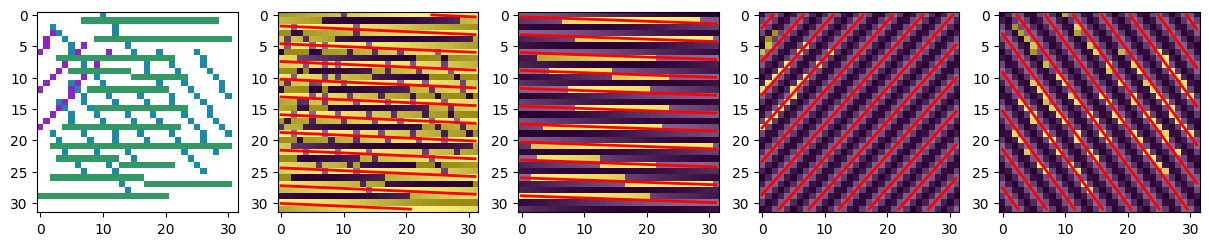

In [24]:
k=5
examples_num = 3
fso = FreqShiftOptimization()

Xuv, phase = flg.random_freqs(examples_num=examples_num)
vecs_col, lengths, lines_mask, vecs_slope, vecs_bias, Iuvx, vec_angle = flg.gen_vecs(Xuv, phase)
I, masks, lines_mask, vecs_col2 = vd.draw_vecs(vecs_col, lines_mask, lengths)
Cl, Cl_centroids = GaussianMixtureComponents(I, max_clusters=10)
cl_num = len(Cl)

top_phases, top_coords, top_Iuvx = TopKFreqs(freq_filter_size=2, pool_size=3, top_k=k, size=32)(Cl)
props_Iuvx, props_vecs_col, props_lines_mask, props_Xuv = fso(top_coords, top_phases, Cl)

fig, axs = plt.subplots(1, cl_num+1, figsize=((cl_num+1)*3, 3))

axs[0].imshow(I)

for ax, pI, c, vecs in zip(axs[1:], props_Iuvx, Cl, props_vecs_col):
    ax.imshow(c)
    ax.imshow(pI[0], cmap='gray', alpha=0.4)

    for v in vecs[0]:
        ax.plot(v[:,0], v[:,1], color='red', linewidth=2.)

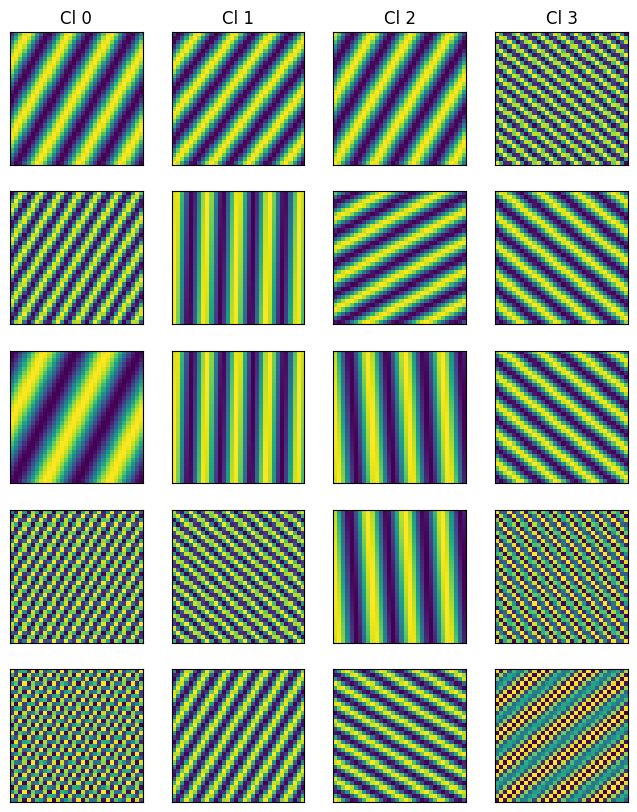

In [16]:
fig, axs = plt.subplots(k, cl_num, figsize=(cl_num*2,k*2))

for j in range(cl_num):
    axs[0,j].set_title(f'Cl {j}')
    for i in range(k):
        axs[i,j].imshow(props_Iuvx[j,i])
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])

## 10. Gaussian Mixture Frequency Extraction Experiments

The experimental blocks under this heading apply `TopKFreqs` and `FreqShiftOptimization` to GMM clusters and visualize:
- How well top-k extracted frequencies reconstruct cluster-specific line patterns.
- The effect of frequency shifts on alignment scores (F1/IoU) between synthetic proposals and clustered masks.
- The behavior of model selection criteria (BIC/AIC) for choosing the number of clusters.
These experiments provide **quantitative and visual evidence** that a small number of properly shifted frequencies can explain complex, repetitive line structures.

In [20]:
cl_num = 4

In [33]:
top_coords.shape, top_phases.shape, top_Iuvx.shape

(TensorShape([4, 5, 2]), TensorShape([4, 5, 1]), TensorShape([4, 5, 32, 32]))

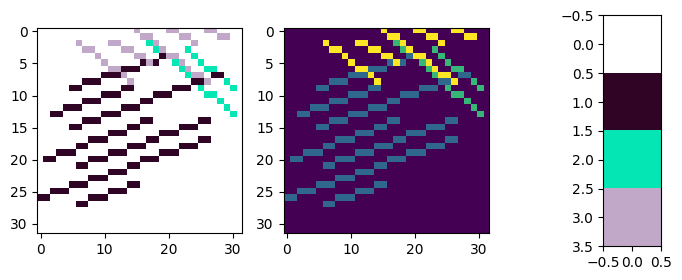

In [34]:
Xuv, phase = flg.random_freqs(examples_num=3)
vecs_col, lengths, lines_mask, vecs_slope, vecs_bias, Iuvx, vec_angle = flg.gen_vecs(Xuv, phase)
I, masks = vd.draw_vecs(vecs_col, lines_mask, lengths)

X = SqueezeImg()(I[tf.newaxis])[0]
gm = GaussianMixture(n_components=cl_num, max_iter=100).fit(X)

clusters = np.reshape(gm.predict(X), (32,32))

Cl = tf.stack([tf.where(clusters==i, 1.0, 0.0)[...,tf.newaxis] for i in range(cl_num)])

fig, axs = plt.subplots(1,3, figsize=(9,3))
axs[0].imshow(I)
axs[1].imshow(clusters)
axs[2].imshow(gm.means_[:,np.newaxis])

In [120]:
gm.means_.shape

(4, 3)

In [33]:
for i in range(1,10):
    gm = GaussianMixture(n_components=i, max_iter=100).fit(X)
    print(i, gm.bic(X), gm.aic(X))

1 -7559.760469714699 -7604.143715965094
2 -29006.106471593976 -29099.804435900365
3 -33272.742575009404 -33415.75525737179
4 -34659.73296815216 -34852.060368570536
5 -34590.41825009616 -34832.060368570536
6 -34521.103532040164 -34812.060368570536
7 -34451.788813984174 -34792.060368570536
8 -34382.47409592818 -34772.060368570536
9 -34313.15937787219 -34752.060368570536


/home/fzzyfoxx/.local/lib/python3.10/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/fzzyfoxx/.local/lib/python3.10/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/fzzyfoxx/.local/lib/python3.10/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/fzzyfoxx/.local/lib/python3.10/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/fzzyfo

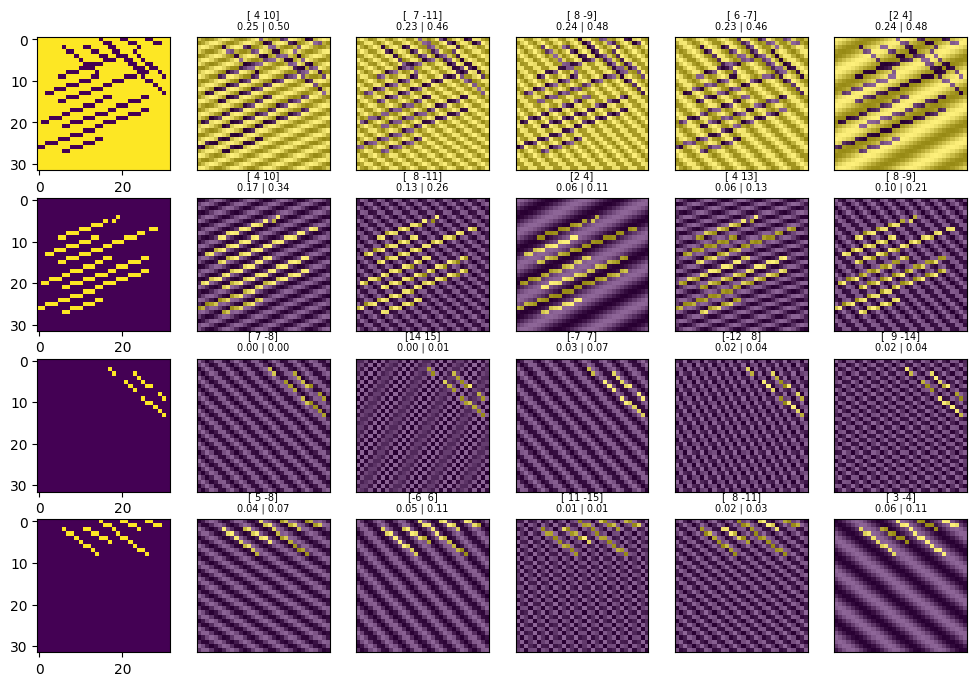

In [37]:
k=5
top_phases, top_coords, top_Iuvx = TopKFreqs(freq_filter_size=2, pool_size=3, top_k=5, size=32)(Cl)

fig, axs = plt.subplots(4,k+1, figsize=((k+1)*2,8))

for m in range(cl_num):
    axs[m,0].imshow(Cl[m])

    for i in range(k):
        axs[m,i+1].imshow(Cl[m])
        axs[m,i+1].imshow(top_Iuvx[m,i], cmap='gray', alpha=0.4)
        v = IoU(Cl[m,...,0], tf.nn.relu(top_Iuvx[m,i]))
        f1 = F1(Cl[m,...,0], tf.nn.relu(top_Iuvx[m,i]))
        axs[m,i+1].set_title('{:s}\n{:.2f} | {:.2f}'.format(str(top_coords[m,i].numpy()),v, f1), fontsize=7)
        axs[m,i+1].set_xticks([])
        axs[m,i+1].set_yticks([])


(4, 5, 21, 21, 2) (4, 5, 2) (21,)
(3, 32, 32)
(4, 5, 21, 21)


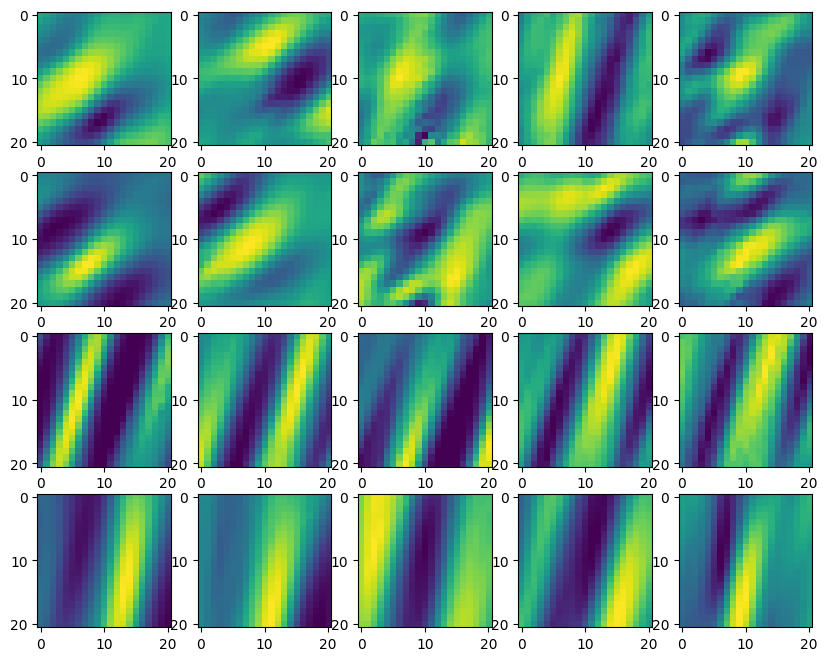

In [38]:
shifts = tf.range(-1.,1.1, 0.1)
shifts_grid = tf.stack(tf.meshgrid(shifts, shifts), axis=-1)
top_Xuv = tf.cast(top_coords[:,:,tf.newaxis, tf.newaxis], tf.float32)+shifts_grid[tf.newaxis, tf.newaxis]
print(top_Xuv.shape, top_coords.shape, shifts.shape)
xy = xy_coords((32,32))

angle = xy[tf.newaxis, tf.newaxis, tf.newaxis, tf.newaxis]*top_Xuv[:,:,:,:,tf.newaxis, tf.newaxis]/32*2*math.pi
top_Iuvx = tf.cos(top_phases[...,tf.newaxis,tf.newaxis,tf.newaxis]*math.pi+tf.reduce_sum(angle, axis=-1))
print(Iuvx.shape)

a = tf.nn.relu(SqueezeImg()(top_Iuvx[...,tf.newaxis])[...,0])
b = SqueezeImg()(Cl[:,tf.newaxis, tf.newaxis, tf.newaxis])[...,0]

#scores = tf.reduce_sum(a*b, axis=-1)/(tf.reduce_sum(a+b, axis=-1)+1e-6)
scores = F1(b,a, axis=-1)
print(scores.shape)

fig, axs = plt.subplots(cl_num, k, figsize=(k*2,cl_num*2))

for m in range(cl_num):
    for i in range(k):
        axs[m,i].imshow(scores[m,i])



(4, 5, 1, 2) (21, 21, 2)
(4, 5, 32, 32)


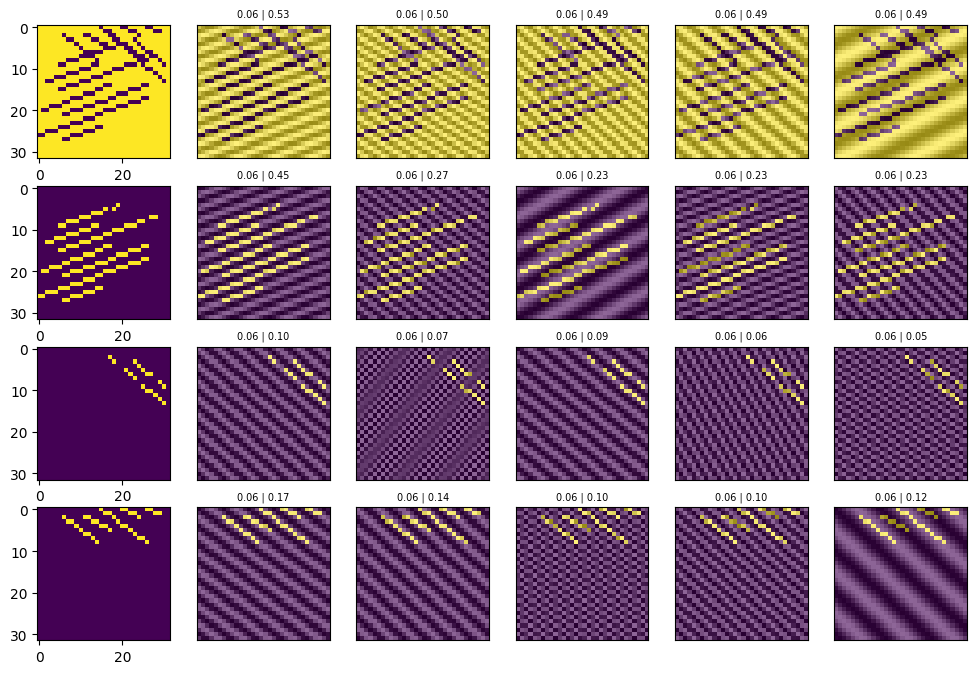

In [39]:
shift_coords, shift_scores = top_k2D(scores, k=1)
print(shift_coords.shape, shifts_grid.shape)
top_shifts = tf.gather_nd(top_Iuvx, shift_coords[:,:,tf.newaxis,:,::-1], batch_dims=2)[:,:,0,0]
print(top_shifts.shape)

fig, axs = plt.subplots(4,k+1, figsize=((k+1)*2,8))

for m in range(cl_num):
    axs[m,0].imshow(Cl[m])

    for i in range(k):
        axs[m,i+1].imshow(Cl[m])
        axs[m,i+1].imshow(top_shifts[m,i], cmap='gray', alpha=0.4)
        f1 = F1(Cl[m,...,0], tf.nn.relu(top_shifts[m,i]))
        axs[m,i+1].set_title('{:.2f} | {:.2f}'.format(v, f1), fontsize=7)
        axs[m,i+1].set_xticks([])
        axs[m,i+1].set_yticks([])

In [68]:
shift_coords.shape, top_coords.shape, shifts_grid.shape, Iuvx.shape, shift_coords[:,:,tf.newaxis,:,::-1].shape

(TensorShape([4, 5, 1, 2]),
 TensorShape([4, 5, 2]),
 TensorShape([21, 21, 2]),
 TensorShape([4, 5, 21, 21, 32, 32]),
 TensorShape([4, 5, 1, 1, 2]))

In [70]:
shift_coords[:,:,tf.newaxis].shape, shifts_grid[tf.newaxis, tf.newaxis].shape

(TensorShape([4, 5, 1, 1, 2]), TensorShape([1, 1, 21, 21, 2]))

In [126]:
top_Xuv = tf.gather_nd(top_Xuv, shift_coords[:,:,tf.newaxis,:,::-1], batch_dims=2)[:,:,0,0]

In [97]:
top_Xuv = tf.gather_nd(top_Xuv, shift_coords[:,:,tf.newaxis,:,::-1], batch_dims=2)[:,:,0,0]
_, top_freqs_idxs = tf.math.top_k(tf.squeeze(shift_scores, axis=-1), 2)
top_Xuv = tf.gather(top_Xuv, top_freqs_idxs, axis=1, batch_dims=1)
top_phases = tf.gather(top_phases, top_freqs_idxs, axis=1, batch_dims=1)

In [106]:
top_Xuv.shape, Xuv.shape, top_phases.shape, phase.shape

(TensorShape([4, 5, 2]),
 TensorShape([3, 2]),
 TensorShape([4, 5, 1]),
 TensorShape([3, 1]))

In [127]:
props_flg = FreqLinesGenerator(batch_dims=2)
props_vecs_col, props_lengths, props_lines_mask, props_vecs_slope, props_vecs_bias, props_Iuvx, props_vec_angle = props_flg.gen_vecs(top_Xuv, top_phases)
#I, masks = vd.draw_vecs(vecs_col, lines_mask, lengths)

In [128]:
props_Iuvx.shape, props_vecs_col.shape, props_lines_mask.shape

(TensorShape([4, 5, 32, 32]),
 TensorShape([4, 5, 32, 2, 2]),
 TensorShape([4, 5, 32]))

In [119]:
lines_mask[-1,0]

<tf.Tensor: shape=(32,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>

## 11. Vector Proposals and Hungarian Matching

At this stage the notebook moves from pixel masks to **explicit vector representations of lines**. It defines utilities to:
- Filter line segments using binary masks (`FilterVecsWithMask`).
- Compute angles, lengths, and centers of segment vectors.
- Build similarity measures over these features and aggregate them into cross-scores between sets of ground-truth and proposed vectors.
Using the Hungarian algorithm (`linear_sum_assignment`), the code computes an **optimal bipartite matching** between true lines and proposed lines. This enables:
- Precise evaluation of proposal quality in vector space.
- Alignment of synthetic proposals with true repetitive line structures for further metric or loss design.

In [10]:
def FilterVecsWithMask(vecs, lines_mask):
    vecs = tf.reshape(vecs, (-1,2,2))
    vecs_mask = tf.reshape(lines_mask, (-1,))
    vecs_mask_idxs = tf.where(vecs_mask>0)
    vecs = tf.gather(vecs, vecs_mask_idxs[:,0], axis=0)
    return vecs

def VecAngles(v, split_axis=-2):
    p0, p1 = tf.split(v, 2, axis=split_axis)
    vecx, vecy = tf.split(p1-p0, 2, axis=-1)
    vec_angle = tf.math.atan2(vecy,vecx)
    return tf.squeeze(vec_angle, axis=-1)

def VecLengths(v, split_axis=-2):
    p0, p1 = tf.split(v, 2, axis=split_axis)
    return tf.reduce_sum((p1-p0)**2, axis=-1)**0.5

def VecCenters(v, axis=-2):
    return tf.reduce_mean(v, axis=axis)

def cross_diff(a,b):
    return a[...,tf.newaxis,:]-b[...,tf.newaxis,:,:]

def AnglesDist(a, b, gamma=1):
    return tf.abs(tf.sin(cross_diff(a,b)))**gamma

def LengthsDist(a, b, gamma=1):
    return tf.abs(cross_diff(a,b))**gamma

def CentersDist(a, b, gamma=1):
    return tf.reduce_sum(tf.abs(cross_diff(a,b))**gamma, axis=-1, keepdims=True)**(1/gamma)

def VecCrossScores(vecs_true,vecs_pred, weights):
    pred_angles = VecAngles(vecs_pred)
    pred_lengths = VecLengths(vecs_pred)
    pred_centers = VecCenters(vecs_pred)

    true_angles = VecAngles(vecs_true)
    true_lengths = VecLengths(vecs_true)
    true_centers = VecCenters(vecs_true)

    sim_weights = weights/tf.reduce_sum(weights, axis=-1, keepdims=True)
    angles_score = AnglesDist(pred_angles, true_angles)
    lengths_score = LengthsDist(pred_lengths, true_lengths)
    centers_score = CentersDist(pred_centers, true_centers)

    return tf.reduce_sum(tf.concat([angles_score, lengths_score, centers_score], axis=-1)*sim_weights, axis=-1)

In [19]:
lines_mask.shape, vecs_col.shape, masks.shape, props_vecs_col.shape, props_lines_mask.shape

(TensorShape([3, 32]),
 TensorShape([3, 32, 2, 2]),
 TensorShape([3, 32, 32, 1]),
 TensorShape([4, 5, 32, 2, 2]),
 TensorShape([4, 5, 32]))

(9, 2, 2) (20, 32, 2, 2) (20, 32)


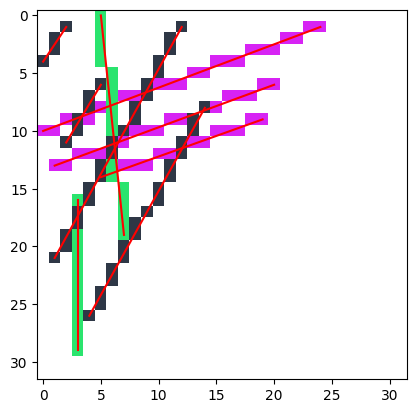

In [36]:
vecs_true = FilterVecsWithMask(vecs_col, lines_mask)
vecs_pred = tf.reshape(props_vecs_col, (-1, 32, 2, 2))#FilterVecsWithMask(props_vecs_col, props_lines_mask)
vecs_pred_masks = tf.reshape(props_lines_mask, (-1, 32))
print(vecs_true.shape, vecs_pred.shape, vecs_pred_masks.shape)
plt.imshow(I)

plt.plot(tf.transpose(vecs_true[:, :,0], [1,0]), tf.transpose(vecs_true[:, :,1], [1,0]), color='red')
plt.show()

(20, 3, 32, 32)
tf.Tensor([[ 5 12 16]], shape=(1, 3), dtype=int64) tf.Tensor([[2 0 1]], shape=(1, 3), dtype=int64)
(3, 32, 2, 2) (3, 32, 2, 2)
(50, 2, 2) (22, 2, 2)
(50, 22)
(22, 2, 2) (22, 2, 2)


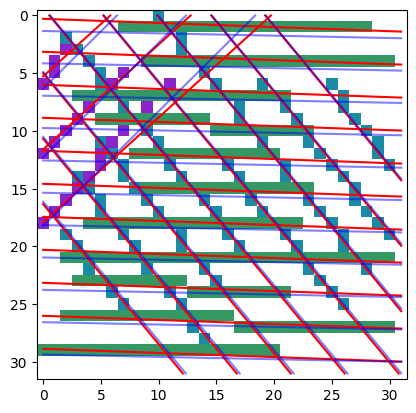

In [25]:
vecs_true = vecs_col#FilterVecsWithMask(vecs_col, lines_mask)
vecs_true_masks = lines_mask
vecs_pred = tf.reshape(props_vecs_col, (-1, 32, 2, 2))#FilterVecsWithMask(props_vecs_col, props_lines_mask)
vecs_pred_masks = tf.reshape(props_lines_mask, (-1, 32))

sim_weights = tf.constant([[[[0.3, 0.3, 0.8]]]])
full_cross_scores = VecCrossScores(vecs_true[tf.newaxis]/32, vecs_pred[:,tf.newaxis]/32, sim_weights)
print(full_cross_scores.shape)
full_cross_scores = tf.reduce_sum(tf.reduce_min(full_cross_scores, axis=-2)*vecs_true_masks[tf.newaxis], axis=-1)/tf.reduce_sum(vecs_true_masks, axis=-1)[tf.newaxis]

pred_idxs, true_idxs = tf.split(tf.convert_to_tensor(tf.numpy_function(linear_sum_assignment, [full_cross_scores], [tf.int64, tf.int64])), 2, axis=0)

vecs_pred_paired = tf.gather(vecs_pred, pred_idxs[0], axis=0)
vecs_true_paired = tf.gather(vecs_true, true_idxs[0], axis=0)

mask_pred_paired = tf.gather(vecs_pred_masks, pred_idxs[0], axis=0)
mask_true_paired = tf.gather(vecs_true_masks, true_idxs[0], axis=0)

print(pred_idxs, true_idxs)
print(vecs_pred_paired.shape, vecs_true_paired.shape)

vecs_pred_paired_filtered = FilterVecsWithMask(vecs_pred_paired, mask_pred_paired)
vecs_true_paired_filtered = FilterVecsWithMask(vecs_true_paired, mask_true_paired)

print(vecs_pred_paired_filtered.shape, vecs_true_paired_filtered.shape)

paired_scores = VecCrossScores(vecs_true_paired_filtered/32, vecs_pred_paired_filtered/32, sim_weights[0,0])
print(paired_scores.shape)

pred_vec_idxs, true_vec_idxs = tf.split(tf.convert_to_tensor(tf.numpy_function(linear_sum_assignment, [paired_scores], [tf.int64, tf.int64])), 2, axis=0)

pred_selected_vecs = tf.gather(vecs_pred_paired_filtered, pred_vec_idxs[0], axis=0)
true_selected_vecs = tf.gather(vecs_true_paired_filtered, true_vec_idxs[0], axis=0)

print(pred_selected_vecs.shape, true_selected_vecs.shape)

plt.imshow(I)

plt.plot(tf.transpose(pred_selected_vecs[:, :,0], [1,0]), tf.transpose(pred_selected_vecs[:, :,1], [1,0]), color='red')
plt.plot(tf.transpose(true_selected_vecs[:, :,0], [1,0]), tf.transpose(true_selected_vecs[:, :,1], [1,0]), color='blue', alpha=0.5)
plt.show()

In [ ]:
fig, axs = plt.subplots(1, examples_num, figsize=(examples_num*3, 3))

for i in range(examples_num):
    v_pred = vecs_pred_paired[i]
    v_true = vecs_true_paired[i]
    axs[i].imshow(I)

    axs[i].plot(tf.transpose(v_pred[:, :,0], [1,0]), tf.transpose(v_pred[:, :,1], [1,0]), color='red')
    axs[i].plot(tf.transpose(v_true[:, :,0], [1,0]), tf.transpose(v_true[:, :,1], [1,0]), color='blue', linewidth=2.0)

    axs[i].scatter(vecs_pred_centers_paired[i,:,0]*32, vecs_pred_centers_paired[i,:,1]*32, marker='+', color='red')
    axs[i].scatter(vecs_true_centers_paired[i,:,0]*32, vecs_true_centers_paired[i,:,1]*32, marker='+', color='blue')

## 12. Non-Max Suppression in Vector Space

The **non-max suppression (NMS)** section performs suppression directly over vector-level similarities, rather than bounding boxes. By combining angle, length, and center similarities into a single overlap score, it:
- Identifies highly redundant line proposals that likely describe the same underlying pattern.
- Retains a compact, diverse set of line vectors that still explain the observed repetitive structure.
Vector-space NMS is an essential post-processing step for systems that output many overlapping line hypotheses, ensuring that the final representation of repetitive linear patterns is both accurate and parsimonious.

In [60]:


props_angles = VecAngles(vecs_pred)
props_lengths = VecLengths(vecs_pred/32)
props_centers = VecCenters(vecs_pred/32)

angles_cross_similarity = 1-AnglesDist(props_angles, props_angles)
lengths_cross_similarity = 1-LengthsDist(props_lengths, props_lengths)
centers_cross_similarity = 1-CentersDist(props_centers, props_centers)

sim_weights = tf.constant([[[0.2, 0.2, 0.6]]])
overlaps = tf.reduce_sum(tf.concat([angles_cross_similarity, lengths_cross_similarity, centers_cross_similarity], axis=-1)*sim_weights, axis=-1)
s = len(overlaps)
o_xy = xy_coords((s,s))
#overlaps *= tf.where(o_xy[...,0]==o_xy[...,1], 0.0, 1.0)
print(props_Xuv.shape, props_angles.shape, props_lengths.shape, props_centers.shape)
print(angles_cross_similarity.shape, lengths_cross_similarity.shape, centers_cross_similarity.shape, overlaps.shape)

(4, 5, 2) (253, 1) (253, 1) (253, 2)
(253, 253, 1) (253, 253, 1) (253, 253, 1) (253, 253)


In [61]:
tf.image.non_max_suppression_overlaps(overlaps, tf.random.uniform((s,), 0.4, 0.6), max_output_size=s, overlap_threshold=0.95)

<tf.Tensor: shape=(82,), dtype=int32, numpy=
array([107,  45, 237,   2, 158, 104, 148, 127,  88, 120, 180,  95, 203,
       212, 231, 209, 140, 131, 168, 118, 152, 164, 249, 149,  67, 157,
       137, 144,  98, 193, 185,  17, 186,  94, 160, 167,  96, 173, 189,
       103, 242, 100, 143, 178, 142, 169,  66, 200,  20, 250,  60, 162,
       198, 230, 192,  55, 134, 188, 174,   3, 248, 155, 156, 247,  58,
        56,  69, 110, 205, 194, 215, 176, 251, 246,   1,  99,  86, 245,
        29,  90, 252, 229], dtype=int32)>

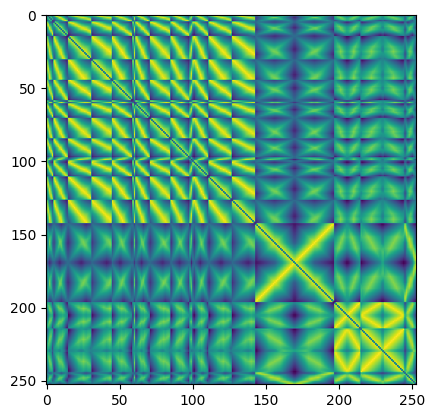

In [44]:
plt.imshow(overlaps)

In [51]:
a,b, scores

(<tf.Tensor: shape=(1, 2, 2), dtype=float32, numpy=
 array([[[12.319047,  0.      ],
         [14.179048, 31.      ]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2, 2), dtype=float32, numpy=
 array([[[ 1.6523794,  0.       ],
         [ 3.5123796, 31.       ]]], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.8], dtype=float32)>)

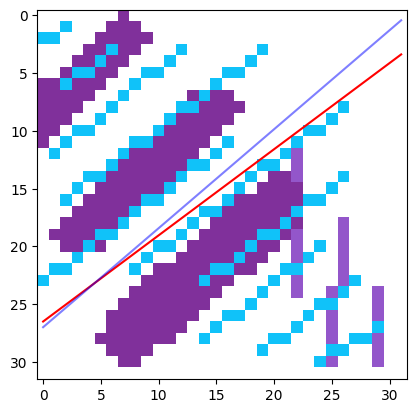

In [55]:
top_pair, scores = top_k2D(tf.where(overlaps>0.95, 0.0, overlaps), k=1)
a,b = tf.split(top_pair, 2, axis=-1)
a = tf.gather(vecs_pred, a[:,0], axis=0)
b = tf.gather(vecs_pred, b[:,0], axis=0)

plt.imshow(I)
for v in a:
    plt.plot(v[:,0], v[:,1], color='red')

for v in b:
    plt.plot(v[:,0], v[:,1], color='blue', alpha=0.5)

In [42]:


props_angles = VecAngles(props_vecs_col)